In [1]:
import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import string
import time
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%load_ext autoreload
%autoreload 2

from rnn import RNN, PrepareData

torch.cuda.is_available()

True

In [2]:
#input_dim = 7
hidden_dim = 30
num_layers = 2
seq_size = 25
all_letters = string.printable
n_letters = len(all_letters)

In [3]:
dataset = PrepareData('input.txt', seq_size, val_ratio=0.2)
#dataset = PrepareData('sample-music2.txt', seq_size)
train_data, val_data = dataset.dataset()

In [4]:
def inputTensor(line):
    if len(line) == 1:
        tensor = torch.zeros(1, n_letters)
        tensor[0, all_letters.find(line[0])] = 1
    else:
        tensor = torch.zeros(len(line)-1, n_letters)
        for idx, letter in enumerate(line[:-1]):
            tensor[idx, all_letters.find(letter)] = 1
    return Variable(tensor.cuda())
        
def targetTensor(line):
    letter_indexes = [all_letters.find(letter) for letter in line[1:]]
    return Variable(torch.LongTensor(letter_indexes).cuda())

def save_model(model, path):
    torch.save(model.state_dict(), path)
    
def load_model(model, path):
    model.load_state_dict(torch.load(path))

In [5]:
model = RNN(n_letters, hidden_dim, num_layers=num_layers, output_size=n_letters)
model = model.cuda()
criterion = nn.CrossEntropyLoss()

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [7]:
n_epochs = 20
all_losses = []
val_losses = []
train_losses = []
print_every = 2000
init_hidden_every = 35

start_time = time.time()

for epoch in range(n_epochs):
    train_cnt = 0
    val_cnt = 0
    total_loss = 0.
    val_total_loss = 0.
    
    
    model.hidden = model.init_hidden()
    
    #dataset.shuffle_data()
    #train_data, val_data = dataset.dataset()
    
    for sentence in train_data:
        model.zero_grad()
        
        loss = 0.
        inputs = inputTensor(sentence)
        targets = targetTensor(sentence)
        
        preds = model(inputs)
        loss = criterion(preds, targets)
            
        loss.backward(retain_graph=True)
        optimizer.step()
        total_loss += loss
        train_cnt += 1
        
        if train_cnt % init_hidden_every == 0:
            model.hidden = model.init_hidden()
        
        if train_cnt % print_every == 0:
            total_loss /= print_every
            all_losses.append(total_loss)
            uptime = time.time() - start_time
            print('%dm:%ds -- [%d, %d], loss: %f' % (uptime/60, uptime%60, epoch, train_cnt, total_loss.data[0]))
            total_loss = 0
    
    for sentence in val_data:
        model.zero_grad()
        
        inputs = inputTensor(sentence)
        targets = targetTensor(sentence)
        
        preds = model(inputs)
        loss = criterion(preds, targets)
        val_cnt += 1
        val_total_loss += loss

        if val_cnt % print_every == 0:
            val_total_loss /= print_every
            val_losses.append(val_total_loss)
#             uptime = time.time() - start_time
#             print('%dm:%ds -- [%d, %d], loss: %f' % (uptime/60, uptime%60, epoch, train_cnt, total_loss.data[0]))
            val_total_loss = 0
scheduler.step()

1m:36s -- [0, 2000], loss: 3.411832
3m:13s -- [0, 4000], loss: 3.006377
4m:52s -- [0, 6000], loss: 2.557594
6m:26s -- [0, 8000], loss: 2.429645
8m:2s -- [0, 10000], loss: 2.189301
9m:34s -- [0, 12000], loss: 2.103100
11m:11s -- [0, 14000], loss: 2.072515
14m:14s -- [1, 2000], loss: 2.514077
15m:45s -- [1, 4000], loss: 2.370968
17m:19s -- [1, 6000], loss: 2.017518
18m:55s -- [1, 8000], loss: 1.967444
20m:31s -- [1, 10000], loss: 1.815888
22m:9s -- [1, 12000], loss: 1.828645
23m:47s -- [1, 14000], loss: 1.868741
26m:49s -- [2, 2000], loss: 2.256952
28m:26s -- [2, 4000], loss: 2.182657
30m:3s -- [2, 6000], loss: 1.872669
31m:40s -- [2, 8000], loss: 1.851420
33m:19s -- [2, 10000], loss: 1.696182
34m:56s -- [2, 12000], loss: 1.728078
36m:33s -- [2, 14000], loss: 1.774105
39m:41s -- [3, 2000], loss: 2.108062
41m:25s -- [3, 4000], loss: 2.071518
43m:2s -- [3, 6000], loss: 1.787701
44m:42s -- [3, 8000], loss: 1.770782
46m:22s -- [3, 10000], loss: 1.626316
48m:2s -- [3, 12000], loss: 1.664878
4

KeyboardInterrupt: 

In [17]:
def test(start_with, max_length, temperature=1):
    model.hidden = model.init_hidden()
    seq = str(start_with)
    idx = []
    
    if len(start_with) > 1:
        inputs = inputTensor(seq)
        output = model(inputs)
    
    inputs = inputTensor(seq[-1])
    
    for i in range(max_length):
        output = model(inputs)
        #pr = F.softmax(output.data, 1)  //pytorch 3.0+
        pr = F.softmax(output.data/temperature)
        pr = pr.cpu().data.numpy().squeeze()
        pred = np.random.choice(n_letters, 1, p=pr)
        
        seq += all_letters[pred[0]]
        idx.append(pred[0])
        inputs = inputTensor(seq[-1])
    return seq, idx

def teacher_forcing_test(sentence):
    inputs = inputTensor(sentence)
    output = model(inputs)
    _, preds = torch.max(output.data, 1)
    seq = [all_letters[pred] for pred in preds ]
    return ''.join(seq)

In [56]:
test_seq = val_data[0]
start_char = test_seq[:10]

seq, idx = test(start_char, 900)
print('Generated sequence: %s' % (seq))
#print('Sequence index: ', idx)
#print('Test sequence: %s' % test_seq)

Generated sequence: $
X:1
T: Liu tote obdariel and
R:aise
arand tham Oem"LON Geanlais O'Deirle \'O. Cehssinau
C:Th Gabas Mel
R:aimbamminll Limammay
A:Sre hon Sto Asten Oe"MDyatris Rost, The Gimmia bisoiphsco? nataian
T:Bince
R:on bonsa-r
R:d:hr- be-ligd
Z:id:hansoaptoit a ewmourd Rellgc.
C:Bokle
Z:id:hn-par0-09
M:1/4
L:1/8
K:G
n:mabs
cdef e3 eG cdc | A2 :|
|: d f=fe | e2fg ddB | c2d cB | G2 G>A B>A|cBAA | B2c Ad cB|c2 d2:|
P:Varieqlanf6 :: 1
|: D2G F>E | G4 F2 | G3 G3 |A3 GAGG | G4 :|
V:rriattons
V:1
"D"Ac BB|A2 G2 F2 ||
"D>F2 E EF | G3F FGG) |
A2GA B2A2 | GAB deg2 | e2e2 BddB | B6f2 |
B2A2 A2e2 | d32 (a4b2 [bothainchon: 1
B2 B2G2 D2A | AB c2 dc | 
d2 G2 G2AG | F2A | A3 |:
V:D
D2 ||
#
$
X:8
T:An the Bawmhancellanear (119-08e1
Z:id:hn-air
M:CAnn
Z:id:hn-d-88
Z:id:hn-al-15
M:CHrazrine
S:Nigin
Z:id:hn-air-168
M:2/4
L:1/8
K:\
#
$
X:16
T:At, T:hr-Duvpgeiumoun
R:ar at War Barche (Th Munles Chillo!che
T:Pyaphill
R:Branle
L:


In [58]:
test_seq = val_data[99]
start_char = test_seq[:10]

seq, idx = test(start_char, 900)
print('Generated sequence: %s' % (seq))

Generated sequence: 2c2 dcde | ^d3e e2fd | B2F2 G22 |: A,2D,2 | G2E3G A,3G | D4B2B2 | 
G2AB B2A3B | G2A2 c2c2|c2Ac A3G |2
A2GBBc | c6g | e2BBAF=G3- A2F2 D2DE | EGG B4A4 | 
d3 f3e | f2f ffe/^d2 B2B2g2 | c2B2 A2 | G2B4 G6 : "C"f2b2 a2 | bgB bfe | ffe=c2dB | G2 A3Bde g3g |
feBc -2me2 a2b2g2 \
G2F2F2|D2G2 E2D | A4:|
#
$
X:88
T:Beamfou amcher Hor STo'linat Ohmain
R:airaai tourad
R:a nam, iallchien
R:a:rancen obs Beua
M:6/8
L:1/8
K:G
xt V3 E3 | GAdg 
af g2 |
e2 a2 t3 |
A2 G2 (3e^fu | vbiiitto:: banl Cuilags Hach
R:fral Ponant Mattrit Thar anc.
Z:id:hn-trie- 1
M:2/4
L:2/8
Q:114=10
K:Am
F2E |1
D2G) G1 GDF  D/G/G/B/ | 
c2 c2 B2 | E2 c^c A8 :|
#
$
X:6
T:Binaneuizon peqitranchy
R:donaifr
C:Trince
D:Clance
R:o pronar
Z:id:hn-jid-6
M:1/8
L:1/8
T:Palad fis
Z:id:hn-air patous drin verl doute pal Michigai ha
R:air
B
K:A
A>BGA | AAFE E2DE | 
E  D2E2 G2E2|D2De A2FE | F2E (3G. 
[ba2a2 |bab e2fd | B2dB d3B | A4A3A G2e2 | c3B B2GF | D6EG


In [48]:
test_seq = val_data[0]
seq = teacher_forcing_test(test_seq)
print('Generated sequence: %s' % (seq))
print('Test sequence: %s' % test_seq)

Generated sequence: 1Z:14T:BTanpaun rn n  R:
Test sequence: $
X:1
T: La Montfarine
Z:


In [45]:
#save_model(model, 'full-model.pth')

In [ ]:
plt.figure()
plt.plot(all_losses)

In [13]:
load_model(model, 'full-model.pth')


RNN (
  (input2hidden): Linear (100 -> 30)
  (lstm): LSTM(30, 30, num_layers=2, dropout=0.05)
  (hidden2tag): Linear (30 -> 100)
)

In [74]:
test_seq = val_data[99]
start_char = test_seq[:10]

seq, idx = test('$', 2000, 1.5)
print('Generated sequence: %s' % (seq))

Generated sequence: $n:
z|G2 ED | FG F3-t -Aajb?Gc:Yaifn,
Q:1/28-29
Z:ig-
AAGEG:|
#
$
X:34
T:Fig?i arNor Coten
CE2n3
S:Dammanteacquinnmo pl'Oviso pal Gtl daus
Z:anpd T2ercon
Qorkd e.A6d.
O:mih tutenthd).s ar. Mish Ke. n, pomta:Anin a
GeeG g3g | f4f6 a4 fecd |
A3 A2E3|: F,3 :|
#
$
X:23
T:ores pr
R:h-mommainarle habe oinn
=d2 _edc|1GA B>ded | GAGAB | cBBGGF D2Cv:|
#
$
X:68
T:as?r
Trad
R:ou/ar
R:crranc ca)
Z:ad tovlonyavieranle ib'scrnas.Than'crrairhien| B6
(B, EFgf ^=f2ag |dfb b2uh:|
P:orthin vade-5^6
O: E010
D6i
|: eB D3 | E4 g2 =e^^ma4bc |aced c>AB2 | 
A4A3 d4 BcB,2G,,DDEE | FAEF AC | AAGE G2Bd |dfde a^fd |  
z2f2ee | G2>-2Gc ^d^Ac | B2GABA ||
#
$
X:7E C=DDIN
R:ain
H:vaisel
B:d joutialg
R:aind?td
D:hl'Wick pasir
R:woulas.
M:<c
K:G
A2A ABA (GFm""EE/-F4 ||
|:FAce e3e | G4 :1mz4|\
Z:TrMar Tobys ?M
Z:id:hn-mii--6-1
M:6/8
K:F
"E4z "F"
e2>edBGD Fd-B | BG (5z]GA-|
A^dg2 ag'| g2g| g4b>f | a2 a e | f3gB4dB | 6deu2a2 | a8bab | c4 _efec |
cFGB c2EB
E2bCF |
2BAG B2)GG | D3D F2F>A |
<3c"g>ggb|[aba"

In [28]:
train_l = []
val_l = []
for i in all_losses:
    train_l.append(i.data[0])

for i in val_losses:
    val_l.append(i.data[0])

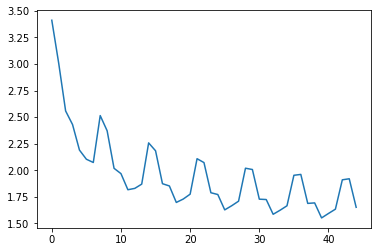

In [29]:
plt.plot(train_l)

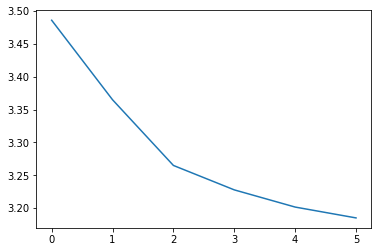

In [30]:
plt.plot(val_l)

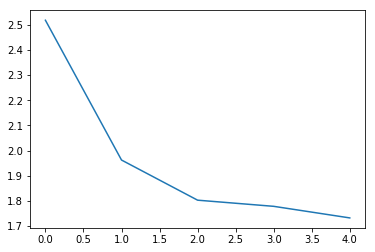

In [39]:
avg_train = np.mean(np.array(train_l).reshape(-1, 9), axis=1)
plt.plot(avg_train)